<a href="https://colab.research.google.com/github/serciex/lane-change/blob/main/V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing Prerequisites

In [1]:
!pip install pygame
!pip install highway-env

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 4.9 MB/s eta 0:00:00


Testing

In [2]:
#Import Libraries
from os import truncate
import math
import gymnasium
import highway_env
from matplotlib import pyplot as plt
import pygame
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
import gym
from random import randint
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from collections import deque
import random
import torch.optim as optim
import tqdm

# Workaround for gym compatibility
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

%matplotlib inline

Environment Definition

In [3]:
# Configure Environment Conditions
config = {
    "lanes_count": 3,
    "lane_width": 3.75,
    "observation": {
        "type": "Kinematics",
        "features": ["x", "y", "vx", "vy", "heading", "lat_off"]
    },
    "action": {"type": "ContinuousAction"},"ego_spawn_random": True,
    "policy_frequency": 10,
}
env = gymnasium.make('highway-v0', render_mode='rgb_array', config=config)
frames = []

# Action Setup
highway_env.envs.common.action.ContinuousAction(env, lateral=True,
                                                longitudinal=True)

IDM Controller

In [4]:
# Environment Manager
class ENV(env.__class__):
  """
  s = (v,a,x,y,thetha,id,w,c) ∈ S

  Lateral Agent State:
  Obs Data:
  x = vehicle x position (x)
  y = vehicle y position (y)
  v = vehicle speed (vx)
  thetha = yaw angle (heading)

  Input:
  a = longitudinal acceleration (longitudinal_control)
  id = target lane id
  w = lane width
  c = road curvature

  Extra Data:
  vy = lateral rate (vy)
  delta_lat_deviation = change in lateral deviation (lat_off)

  """
  def __init__(self, obs, desired_parameters, control_parameters):
    self.obs = obs
    # Unpack initial parameters: [s0, v0]
    self.s0, self.v0 = desired_parameters

    # Unpack control parameters: [a, b, delta, T]
    self.a, self.b, self.delta, self.T = control_parameters

  def ego_state_idm(self):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      self._ego_state_idm = {"x": ax, "y": ay, "vx": avx,"thetha": athetha,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_idm

  def update(self,obs):
    self.obs = obs

  def ego_state_agent(self,target_id):
      ax, ay, avx, avy, athetha, _ = self.obs[0]
      vehicle = env.unwrapped.vehicle

      # Control Parameters
      self.id = target_id

      # Environment Parameters
      self.s,_ = vehicle.lane.local_coordinates(vehicle.position)
      self.w = vehicle.lane.width
      self.c = vehicle.lane.heading_at(np.clip(
          vehicle.lane.local_coordinates(vehicle.position)[0],
          0, vehicle.lane.length))
      self.v = math.sqrt(avx**2+avy**2)

      self._ego_state_agent = {"x": ax, "y": ay, "vx": self.v,"thetha": athetha,
                         "lane_width":self.w,"lane_id":self.id,
                         "self_curvature":self.c,
                         "longitudinal_acceleration":self.a}

      return self._ego_state_agent

  def longitudinal_lead_state(self):
      # Lead State Parameters on the same Lane (5 columns: presence, x, y, vx, vy)
      ego_vehicle = env.unwrapped.vehicle
      lead_vehicle = env.unwrapped.road.neighbour_vehicles(ego_vehicle, lane_index=ego_vehicle.lane_index)[0]

      if lead_vehicle:
          gap = lead_vehicle.position[0] - ego_vehicle.position[0]
          delta_velocity = ego_vehicle.velocity[0] - lead_vehicle.velocity[0]
          self._longitudinal_lead_state = {"x": gap, "vx": delta_velocity}
      else:
          self._longitudinal_lead_state = {"x": 10, "vx": 0}

      return self._longitudinal_lead_state

  def idm_controller(self):
      # Unpack input variables: [s, v, delta_v]
      s, v, delta_v = self.longitudinal_lead_state()['x'], self.ego_state_idm()['vx'], self.longitudinal_lead_state()['vx']

      # Small epsilon to account for very small gaps and avoid division by zero
      epsilon = 1e-6

      # Desired gap: s* = s0 + v*T + (v * delta_v) / (2 * sqrt(a * b))
      desired_gap = self.s0 + max(0, v * self.T + ((v * delta_v) / (2 * math.sqrt(self.a * self.b))))

      # IDM acceleration: a_IDM = a * [ 1 - (v / v0)^delta - (s* / s)^2 ]
      acceleration = self.a * (1 - (v / self.v0)**self.delta - (desired_gap / (s + epsilon))**2)

      return acceleration


  #Reward Function
  def reward_function(self, obs_old, obs_new, target_id, w1=1, w2=1, w3=0.05):
    """
    Reward Function:

    Acceleration Reward: r_acce = w1*f_acce(a_yaw)
    a_yaw = lateral acceleration (self.action)

    Rate Reward: r_rate = w2*f_rate(w_yaw)
    w_yaw = lateral rate (vy)

    Time Reward: r_time = w3*f_time (delta_lat_deviation)
    delta_lat_deviation = change in lateral deviation (self.lat_off)

    Reward = Cummulative Sum of r_acce + Cummulative Sum of r_rate + Cummulative Sum of r_time

    """

    self.target_id = ("0","1",target_id)
    target_lane_object = env.unwrapped.road.network.get_lane(self.target_id)
    vehicle_s, _ = env.unwrapped.vehicle.lane.local_coordinates(env.unwrapped.vehicle.position)
    _ , self.delta_lat_deviaton = target_lane_object.local_coordinates(env.unwrapped.vehicle.position)

    obs = obs_new[0]
    obs_old = obs_old[0]

    w_yaw = (obs[0] * obs[3] - obs[1] * obs[2]) / (obs[0]**2 + obs[1]**2 + 1e-8)
    w_yaw_old = (obs_old[0] * obs_old[3] - obs_old[1] * obs_old[2]) / (obs_old[0]**2 + obs_old[1]**2 + 1e-8)

    self.w_acce = (w_yaw-w_yaw_old)*env.unwrapped.config['policy_frequency']

    # Acceleration Reward
    acce_reward = -1*abs(self.w_acce)

    # Rate Reward
    rate_reward = -1*abs(w_yaw)

    # Time Reward
    time_reward = -0.05 * abs(self.delta_lat_deviaton)

    # Overall Reward
    self.reward = w1*acce_reward + w2*rate_reward + w3*time_reward

    return [self.reward, acce_reward, rate_reward, time_reward]


  def action(self, obs, lateral_action):
      self.obs = obs
      L = env.unwrapped.vehicle.LENGTH
      self.acc = self.idm_controller()

      # Calculate steering angle from lateral acceleration
      self.angle = math.atan(L * lateral_action / self.ego_state_idm()['vx']**2)

      # Return the action as [longitudinal_acceleration, steering_angle]
      calculated_action = [self.acc, self.angle]

      return calculated_action

Agent Defintion

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim=8, action_dim=1, hidden_size=128):
        super().__init__()
        self.action_dim = action_dim

        # Policy head (actor) - Output 2 values: mean and log_std
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, self.action_dim * 2),  # Use self.action_dim here
        )

        # Value head (critic)
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x):
        # Value head
        value = self.critic(x)

        # Policy head
        actor_output = self.actor(x)
        action_mean, action_log_std = torch.split(actor_output, self.action_dim, dim=-1) # Split output

        action_std = torch.exp(action_log_std)
        action_dist = torch.distributions.Normal(action_mean, action_std)

        return action_dist, value

    def action(self, state, deterministic = False):
        action_dist, value = self.forward(state)

        if deterministic:
            action = action_dist.mean
            log_prob = action_dist.log_prob(action)

        else:
          action = action_dist.sample()
          log_prob = action_dist.log_prob(action)

        return action, log_prob, value

Lateral Controller (Gap Checker)

In [6]:
import numpy as np

class Gap_Controller(env.__class__):
    def __init__(self, obs=None, following_gap_threshold=10.0):
        # Optionally store an initial observation if provided.
        if obs is not None:
            self.obs = obs
        # Threshold for safety gap with the following vehicle
        self.following_gap_threshold = following_gap_threshold

    def lane_checker(self):
        """
        Determines which adjacent lane offers the safest gap for a lane change.
        It examines the current lane, the lane to the left, and the lane to the right,
        returning the lane index that has the largest safe front gap available.
        In addition, if the gap with the following vehicle in the target lane is below the safety
        threshold, the lane change is aborted and the current lane is chosen.

        Returns:
            int: The target lane index (the lane with the largest safe gap, or the current lane)
                 if the candidate lane's following vehicle gap is unsafe.
        """
        lane_number = len(env.unwrapped.road.network.lanes_list())
        ego = env.unwrapped.vehicle

        # Initialize front gap values with a default that indicates an unsafe or non-existent gap.
        gap_current_front = -float('inf')
        gap_right_front = -float('inf')
        gap_left_front = -float('inf')

        # Initialize following gap values (gap between ego and the vehicle behind)
        gap_current_follower = float('inf')
        gap_right_follower = float('inf')
        gap_left_follower = float('inf')

        # Get vehicle neighbours in current lane:
        neighbours_current = env.unwrapped.road.neighbour_vehicles(ego, ego.lane_index)
        # neighbours_current[0] is the vehicle ahead and [1] is the following vehicle.
        if neighbours_current:
            if neighbours_current[0]:
                gap_current_front = neighbours_current[0].position[0] - ego.position[0]
            if len(neighbours_current) > 1 and neighbours_current[1]:
                gap_current_follower = ego.position[0] - neighbours_current[1].position[0]

        # Compute the left and right lane indices.
        current_lane = list(ego.lane_index)
        if current_lane[2] > 0:
            lane_left = (current_lane[0], current_lane[1], current_lane[2] - 1)
        else:
            lane_left = ego.lane_index

        if current_lane[2] < (lane_number - 1):
            lane_right = (current_lane[0], current_lane[1], current_lane[2] + 1)
        else:
            lane_right = ego.lane_index

        # Retrieve neighbour vehicles for the right lane.
        neighbours_right = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_right)
        if neighbours_right:
            if neighbours_right[0]:
                gap_right_front = neighbours_right[0].position[0] - ego.position[0]
            if len(neighbours_right) > 1 and neighbours_right[1]:
                gap_right_follower = ego.position[0] - neighbours_right[1].position[0]

        # Retrieve neighbour vehicles for the left lane.
        neighbours_left = env.unwrapped.road.neighbour_vehicles(ego, lane_index=lane_left)
        if neighbours_left:
            if neighbours_left[0]:
                gap_left_front = neighbours_left[0].position[0] - ego.position[0]
            if len(neighbours_left) > 1 and neighbours_left[1]:
                gap_left_follower = ego.position[0] - neighbours_left[1].position[0]

        # Compare the front gaps: current, right, and left.
        front_gaps = [gap_current_front, gap_right_front, gap_left_front]
        best_index = np.argmax(front_gaps)

        # Determine the target lane index based on the best candidate.
        # best_index: 0 => current lane, 1 => right lane, 2 => left lane.
        if best_index == 1:
            candidate_lane = lane_right
            candidate_follower_gap = gap_right_follower
        elif best_index == 2:
            candidate_lane = lane_left
            candidate_follower_gap = gap_left_follower
        else:
            candidate_lane = ego.lane_index
            candidate_follower_gap = gap_current_follower  # in current lane, we don't enforce follower gap condition

        # Check if the candidate lane (if different from the current lane)
        # meets the follower gap condition.
        if candidate_lane != ego.lane_index:
            if candidate_follower_gap < self.following_gap_threshold:
                # The follower gap is too small; do not change lanes.
                target_lane_id = ego.lane_index[2]
            else:
                target_lane_id = candidate_lane[2]
        else:
            target_lane_id = ego.lane_index[2]

        return target_lane_id


Initialize Environment

In [7]:
# Initialize Environment
obs, _ = env.reset()
# IDM Initialization
control_parameters = [0.1, 5, 4, 4]  # a, b, δ, T
desired_parameters = [20, 10.0]       # s0, v0

# Initialize Environment Manager and Reward
state_manager = ENV(obs,control_parameters=control_parameters,desired_parameters=desired_parameters)

# State Manager for Ego and Lead State
ego_state_idm = state_manager.ego_state_idm()
lead_state = state_manager.longitudinal_lead_state()

Training Loop

Always Active (Option 1)

In [8]:
################################################################################
"""Initialization"""
################################################################################

# Agent Initialization
total_steps_taken = 0
lr = 0.01  # Reduced learning rate
gamma = 0.99  # Higher discount factor for better long-term rewards
action_dim = 1  # Lateral acceleration

# Reasonable hyperparameter sizes
buffer_size = int(1e5)  # 100k buffer
batch_size = 256  # Standard batch size
max_timesteps = int(4e4)  # 40k total timesteps

plot_freq_steps = 5000  # Plot every 5000 timesteps

# Epsilon-Greedy Parameters
epsilon = 0.3

# Tracking for performance
timestep_rewards = []  # Store rewards by timestep
timestep_acce_rewards = []  # Store acceleration rewards
timestep_rate_rewards = []  # Store rate rewards
timestep_time_rewards = []  # Store time rewards
global_returns = []  # Cumulative return tracking
loss_history = []  # Loss values
timesteps_list = []  # Track timesteps for plotting
episode_lengths = []  # Track episode lengths
episode_indices = []  # Track episode indices for plotting

target_id = env.unwrapped.vehicle.lane_index[-1]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Environment Information
L = env.unwrapped.vehicle.LENGTH
agent_state = state_manager.ego_state_agent(target_id=target_id)
state_dim = len(agent_state)
action_dim = 1
print(f"State Dimension: {state_dim}, Action Dimension: {action_dim}")

State Dimension: 8, Action Dimension: 1


Model

Hyperparameters

In [9]:
# Define hyperparameters
max_timesteps_per_rollout = 500  # Max timesteps per rollout
K = 10    # Number of policy update epochs
test_rate = 5  # Test every 5 batches
num_test = 0

batch_size = 64
gamma = 0.99
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vf_coeff_cl = 0.5
ent_coef_c2 = 0.01
epsilon = 0.2
gae_lambda = 0.99

# Episode counter
max_episodes_per_rollout = 1
nb_episodes = 1000
nb_batches = round(nb_episodes/max_episodes_per_rollout)

# Define action dimension (continuous action space)
action_dim = 1  # For lateral acceleration

# Initialize model and optimizer
model = ActorCritic(state_dim=state_dim, action_dim=action_dim).to(device)
actor_params = list(model.actor.parameters())
critic_params = list(model.critic.parameters())

actor_optimizer = torch.optim.Adam(actor_params, lr=3e-4)
critic_optimizer = torch.optim.Adam(critic_params, lr=1e-3)

# Tracking variables
total_env_episodes = 0
max_reward = float('-inf')
batch_average_reward_history = []
batch_episode_history = []
individual_test_rewards = []
individual_test_episodes = []

Training Loop

In [10]:
# Initialize plot outside the loop (before the training loop starts)
plt.figure(figsize=(10, 6))
plt.ion()  # Turn on interactive mode

<Figure size 1000x600 with 0 Axes>

  0%|          | 1/1000 [00:03<58:36,  3.52s/it]

Training Batch 1: Collected 90 timesteps Episode Count: 5


  0%|          | 2/1000 [00:04<33:56,  2.04s/it]

Training Batch 2: Collected 24 timesteps Episode Count: 5


  0%|          | 3/1000 [00:06<35:25,  2.13s/it]

Training Batch 3: Collected 57 timesteps Episode Count: 5


  0%|          | 4/1000 [00:09<42:06,  2.54s/it]

Training Batch 4: Collected 77 timesteps Episode Count: 5


  0%|          | 5/1000 [00:12<43:29,  2.62s/it]

Training Batch 5: Collected 53 timesteps Episode Count: 5
Training Batch 6: Collected 62 timesteps Episode Count: 5


  1%|          | 6/1000 [00:17<53:23,  3.22s/it]

Episode 5: Avg Test Reward = -3.04, Max Test Reward = -1.91


  1%|          | 7/1000 [00:20<54:31,  3.29s/it]

Training Batch 7: Collected 89 timesteps Episode Count: 5


  1%|          | 8/1000 [00:23<54:27,  3.29s/it]

Training Batch 8: Collected 64 timesteps Episode Count: 5


  1%|          | 9/1000 [00:25<46:51,  2.84s/it]

Training Batch 9: Collected 44 timesteps Episode Count: 5


  1%|          | 10/1000 [00:27<39:50,  2.41s/it]

Training Batch 10: Collected 38 timesteps Episode Count: 5
Training Batch 11: Collected 67 timesteps Episode Count: 5
Episode 10: Avg Test Reward = -3.03, Max Test Reward = -1.91


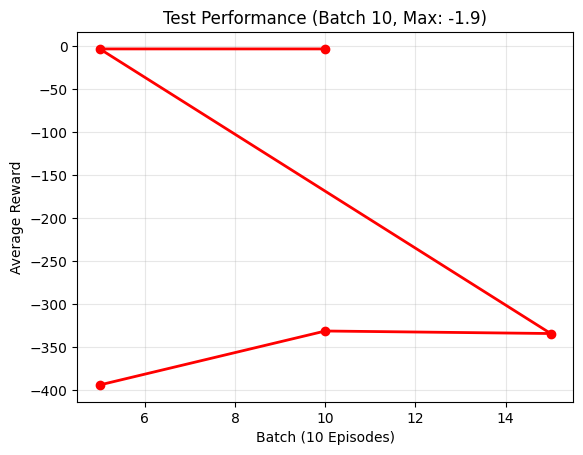

  1%|          | 12/1000 [00:35<52:16,  3.17s/it]

Training Batch 12: Collected 75 timesteps Episode Count: 5


  1%|▏         | 13/1000 [00:37<49:00,  2.98s/it]

Training Batch 13: Collected 53 timesteps Episode Count: 5


  1%|▏         | 14/1000 [00:40<45:47,  2.79s/it]

Training Batch 14: Collected 61 timesteps Episode Count: 5


  2%|▏         | 15/1000 [00:42<46:13,  2.82s/it]

Training Batch 15: Collected 74 timesteps Episode Count: 5
Training Batch 16: Collected 118 timesteps Episode Count: 5


  2%|▏         | 16/1000 [00:50<1:08:42,  4.19s/it]

Episode 15: Avg Test Reward = -2.92, Max Test Reward = -1.91


  2%|▏         | 17/1000 [00:52<58:38,  3.58s/it]  

Training Batch 17: Collected 56 timesteps Episode Count: 5


  2%|▏         | 18/1000 [00:53<48:08,  2.94s/it]

Training Batch 18: Collected 36 timesteps Episode Count: 5


  2%|▏         | 19/1000 [00:55<42:44,  2.61s/it]

Training Batch 19: Collected 47 timesteps Episode Count: 5


  2%|▏         | 20/1000 [00:57<36:40,  2.24s/it]

Training Batch 20: Collected 34 timesteps Episode Count: 5
Training Batch 21: Collected 61 timesteps Episode Count: 5
Episode 20: Avg Test Reward = -3.02, Max Test Reward = -1.91


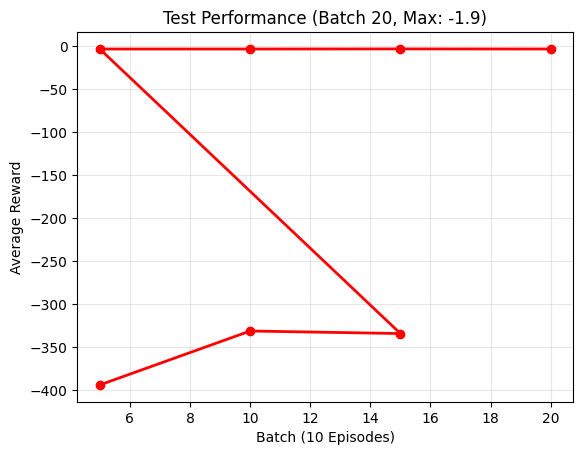

  2%|▏         | 22/1000 [01:06<55:42,  3.42s/it]

Training Batch 22: Collected 70 timesteps Episode Count: 5


  2%|▏         | 23/1000 [01:08<49:57,  3.07s/it]

Training Batch 23: Collected 58 timesteps Episode Count: 5


  2%|▏         | 24/1000 [01:10<41:28,  2.55s/it]

Training Batch 24: Collected 34 timesteps Episode Count: 5


  2%|▎         | 25/1000 [01:13<46:24,  2.86s/it]

Training Batch 25: Collected 68 timesteps Episode Count: 5
Training Batch 26: Collected 45 timesteps Episode Count: 5


  3%|▎         | 26/1000 [01:17<52:38,  3.24s/it]

Episode 25: Avg Test Reward = -3.35, Max Test Reward = -1.91


/tmp/ipython-input-12-1088414899.py:139: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(value.squeeze(),returns)
  3%|▎         | 27/1000 [01:20<48:58,  3.02s/it]

Training Batch 27: Collected 65 timesteps Episode Count: 5


  3%|▎         | 28/1000 [01:24<53:00,  3.27s/it]

Training Batch 28: Collected 76 timesteps Episode Count: 5


  3%|▎         | 29/1000 [01:27<53:29,  3.31s/it]

Training Batch 29: Collected 71 timesteps Episode Count: 5


  3%|▎         | 30/1000 [01:30<52:46,  3.26s/it]

Training Batch 30: Collected 84 timesteps Episode Count: 5
Training Batch 31: Collected 58 timesteps Episode Count: 5
Episode 30: Avg Test Reward = -3.58, Max Test Reward = -3.04


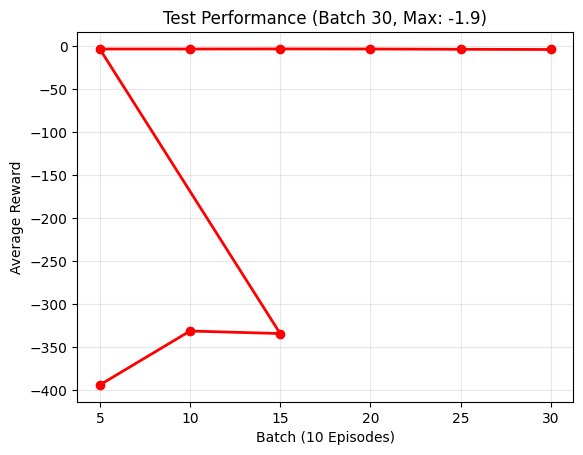

  3%|▎         | 32/1000 [01:39<1:01:05,  3.79s/it]

Training Batch 32: Collected 77 timesteps Episode Count: 5


  3%|▎         | 33/1000 [01:41<53:56,  3.35s/it]  

Training Batch 33: Collected 60 timesteps Episode Count: 5


  3%|▎         | 34/1000 [01:43<46:34,  2.89s/it]

Training Batch 34: Collected 46 timesteps Episode Count: 5


  4%|▎         | 35/1000 [01:45<39:58,  2.49s/it]

Training Batch 35: Collected 35 timesteps Episode Count: 5
Training Batch 36: Collected 57 timesteps Episode Count: 5


  4%|▎         | 36/1000 [01:50<51:38,  3.21s/it]

Episode 35: Avg Test Reward = -2.93, Max Test Reward = -1.91


  4%|▎         | 37/1000 [01:53<52:19,  3.26s/it]

Training Batch 37: Collected 82 timesteps Episode Count: 5


  4%|▍         | 38/1000 [01:55<47:51,  2.99s/it]

Training Batch 38: Collected 60 timesteps Episode Count: 5


  4%|▍         | 39/1000 [01:58<45:38,  2.85s/it]

Training Batch 39: Collected 66 timesteps Episode Count: 5


  4%|▍         | 40/1000 [02:00<42:02,  2.63s/it]

Training Batch 40: Collected 56 timesteps Episode Count: 5
Training Batch 41: Collected 42 timesteps Episode Count: 5
Episode 40: Avg Test Reward = -2.49, Max Test Reward = -1.91


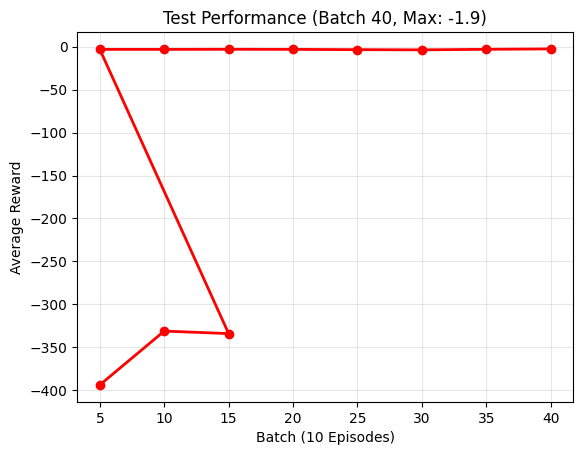

  4%|▍         | 42/1000 [02:05<39:47,  2.49s/it]

Training Batch 42: Collected 23 timesteps Episode Count: 5


  4%|▍         | 43/1000 [02:08<39:54,  2.50s/it]

Training Batch 43: Collected 67 timesteps Episode Count: 5


  4%|▍         | 44/1000 [02:10<37:47,  2.37s/it]

Training Batch 44: Collected 55 timesteps Episode Count: 5


  4%|▍         | 45/1000 [02:12<34:26,  2.16s/it]

Training Batch 45: Collected 44 timesteps Episode Count: 5
Training Batch 46: Collected 48 timesteps Episode Count: 5


  5%|▍         | 46/1000 [02:17<48:04,  3.02s/it]

Episode 45: Avg Test Reward = -3.02, Max Test Reward = -1.91


  5%|▍         | 47/1000 [02:19<45:51,  2.89s/it]

Training Batch 47: Collected 66 timesteps Episode Count: 5


  5%|▍         | 48/1000 [02:22<45:18,  2.86s/it]

Training Batch 48: Collected 71 timesteps Episode Count: 5


  5%|▍         | 49/1000 [02:24<41:37,  2.63s/it]

Training Batch 49: Collected 52 timesteps Episode Count: 5


  5%|▌         | 50/1000 [02:26<39:15,  2.48s/it]

Training Batch 50: Collected 40 timesteps Episode Count: 5
Training Batch 51: Collected 64 timesteps Episode Count: 5
Episode 50: Avg Test Reward = -3.03, Max Test Reward = -1.91


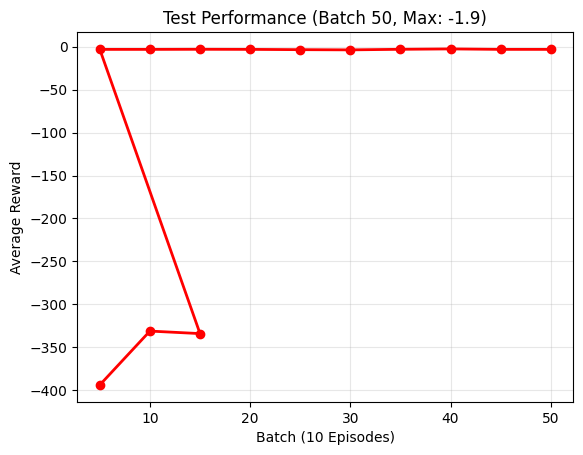

  5%|▌         | 52/1000 [02:33<46:23,  2.94s/it]

Training Batch 52: Collected 59 timesteps Episode Count: 5


  5%|▌         | 53/1000 [02:36<44:51,  2.84s/it]

Training Batch 53: Collected 68 timesteps Episode Count: 5


  5%|▌         | 54/1000 [02:39<45:07,  2.86s/it]

Training Batch 54: Collected 57 timesteps Episode Count: 5


  6%|▌         | 55/1000 [02:41<43:44,  2.78s/it]

Training Batch 55: Collected 61 timesteps Episode Count: 5
Training Batch 56: Collected 55 timesteps Episode Count: 5


  6%|▌         | 56/1000 [02:46<51:18,  3.26s/it]

Episode 55: Avg Test Reward = -3.25, Max Test Reward = -1.91


  6%|▌         | 57/1000 [02:47<42:08,  2.68s/it]

Training Batch 57: Collected 33 timesteps Episode Count: 5


  6%|▌         | 58/1000 [02:49<38:07,  2.43s/it]

Training Batch 58: Collected 48 timesteps Episode Count: 5


  6%|▌         | 59/1000 [02:51<37:28,  2.39s/it]

Training Batch 59: Collected 40 timesteps Episode Count: 5


  6%|▌         | 60/1000 [02:54<39:45,  2.54s/it]

Training Batch 60: Collected 69 timesteps Episode Count: 5
Training Batch 61: Collected 49 timesteps Episode Count: 5
Episode 60: Avg Test Reward = -3.59, Max Test Reward = -3.05


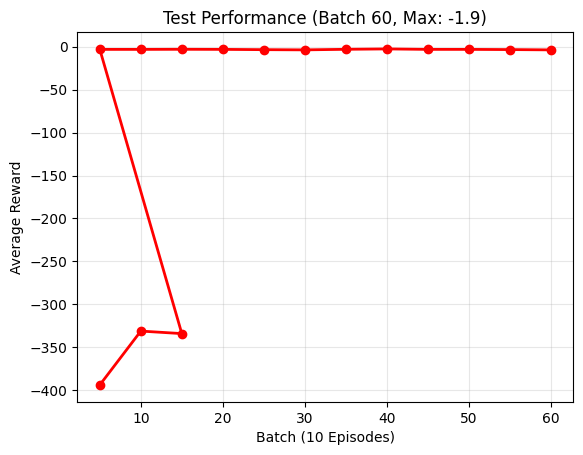

  6%|▌         | 62/1000 [03:00<41:29,  2.65s/it]

Training Batch 62: Collected 39 timesteps Episode Count: 5


  6%|▋         | 63/1000 [03:02<36:11,  2.32s/it]

Training Batch 63: Collected 39 timesteps Episode Count: 5


  6%|▋         | 64/1000 [03:05<40:14,  2.58s/it]

Training Batch 64: Collected 59 timesteps Episode Count: 5


  6%|▋         | 65/1000 [03:07<39:30,  2.54s/it]

Training Batch 65: Collected 62 timesteps Episode Count: 5
Training Batch 66: Collected 64 timesteps Episode Count: 5


  7%|▋         | 66/1000 [03:12<48:53,  3.14s/it]

Episode 65: Avg Test Reward = -3.02, Max Test Reward = -1.91


  7%|▋         | 67/1000 [03:14<42:03,  2.71s/it]

Training Batch 67: Collected 42 timesteps Episode Count: 5


  7%|▋         | 68/1000 [03:17<43:20,  2.79s/it]

Training Batch 68: Collected 53 timesteps Episode Count: 5


  7%|▋         | 69/1000 [03:20<45:13,  2.91s/it]

Training Batch 69: Collected 84 timesteps Episode Count: 5


  7%|▋         | 70/1000 [03:22<39:25,  2.54s/it]

Training Batch 70: Collected 42 timesteps Episode Count: 5
Training Batch 71: Collected 59 timesteps Episode Count: 5
Episode 70: Avg Test Reward = -2.91, Max Test Reward = -1.91


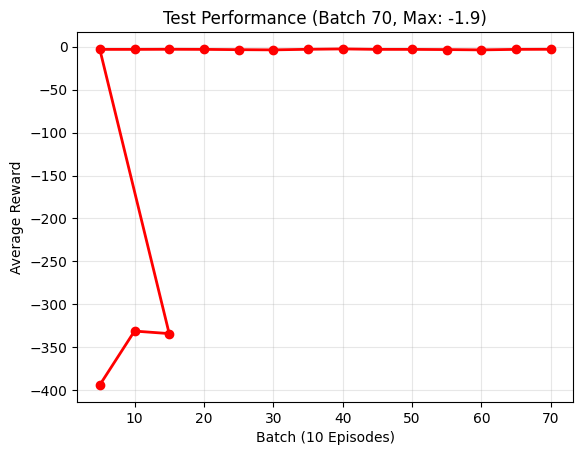

  7%|▋         | 72/1000 [03:28<42:55,  2.78s/it]

Training Batch 72: Collected 32 timesteps Episode Count: 5


  7%|▋         | 73/1000 [03:30<37:28,  2.43s/it]

Training Batch 73: Collected 31 timesteps Episode Count: 5


  7%|▋         | 74/1000 [03:31<33:59,  2.20s/it]

Training Batch 74: Collected 43 timesteps Episode Count: 5


  8%|▊         | 75/1000 [03:34<34:32,  2.24s/it]

Training Batch 75: Collected 60 timesteps Episode Count: 5
Training Batch 76: Collected 31 timesteps Episode Count: 5


  8%|▊         | 76/1000 [03:37<39:41,  2.58s/it]

Episode 75: Avg Test Reward = -3.14, Max Test Reward = -1.91


  8%|▊         | 77/1000 [03:41<44:32,  2.90s/it]

Training Batch 77: Collected 77 timesteps Episode Count: 5


  8%|▊         | 78/1000 [03:43<42:53,  2.79s/it]

Training Batch 78: Collected 63 timesteps Episode Count: 5


  8%|▊         | 79/1000 [03:46<42:25,  2.76s/it]

Training Batch 79: Collected 68 timesteps Episode Count: 5


  8%|▊         | 80/1000 [03:48<39:12,  2.56s/it]

Training Batch 80: Collected 54 timesteps Episode Count: 5
Training Batch 81: Collected 92 timesteps Episode Count: 5
Episode 80: Avg Test Reward = -2.92, Max Test Reward = -1.91


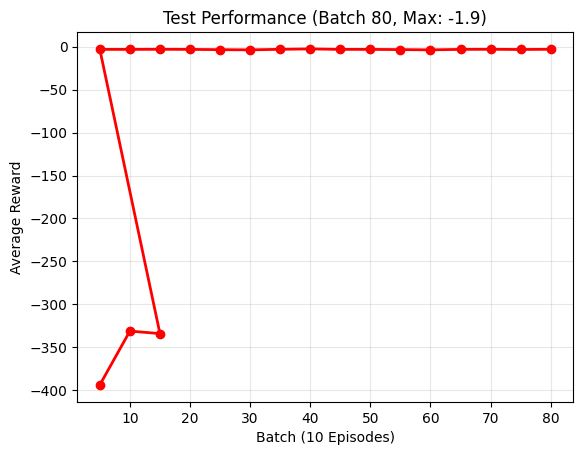

  8%|▊         | 82/1000 [03:57<53:44,  3.51s/it]

Training Batch 82: Collected 80 timesteps Episode Count: 5


  8%|▊         | 83/1000 [03:59<45:39,  2.99s/it]

Training Batch 83: Collected 45 timesteps Episode Count: 5


  8%|▊         | 84/1000 [04:01<40:22,  2.65s/it]

Training Batch 84: Collected 48 timesteps Episode Count: 5


  8%|▊         | 85/1000 [04:02<34:28,  2.26s/it]

Training Batch 85: Collected 35 timesteps Episode Count: 5
Training Batch 86: Collected 46 timesteps Episode Count: 5


  9%|▊         | 86/1000 [04:08<47:27,  3.12s/it]

Episode 85: Avg Test Reward = -3.48, Max Test Reward = -1.93


  9%|▊         | 87/1000 [04:10<42:17,  2.78s/it]

Training Batch 87: Collected 52 timesteps Episode Count: 5


  9%|▉         | 88/1000 [04:12<43:13,  2.84s/it]

Training Batch 88: Collected 78 timesteps Episode Count: 5


  9%|▉         | 89/1000 [04:14<37:14,  2.45s/it]

Training Batch 89: Collected 38 timesteps Episode Count: 5


  9%|▉         | 90/1000 [04:16<34:07,  2.25s/it]

Training Batch 90: Collected 44 timesteps Episode Count: 5
Training Batch 91: Collected 43 timesteps Episode Count: 5
Episode 90: Avg Test Reward = -3.02, Max Test Reward = -1.91


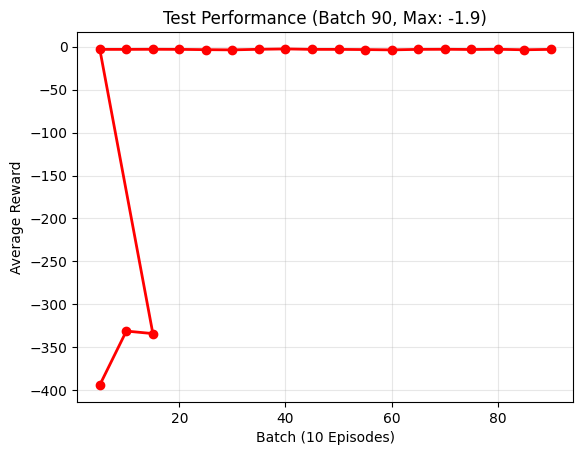

  9%|▉         | 92/1000 [04:23<41:20,  2.73s/it]

Training Batch 92: Collected 53 timesteps Episode Count: 5


  9%|▉         | 93/1000 [04:25<38:46,  2.57s/it]

Training Batch 93: Collected 55 timesteps Episode Count: 5


  9%|▉         | 94/1000 [04:27<36:51,  2.44s/it]

Training Batch 94: Collected 55 timesteps Episode Count: 5


 10%|▉         | 95/1000 [04:30<39:51,  2.64s/it]

Training Batch 95: Collected 61 timesteps Episode Count: 5
Training Batch 96: Collected 51 timesteps Episode Count: 5


 10%|▉         | 96/1000 [04:34<46:37,  3.09s/it]

Episode 95: Avg Test Reward = -3.14, Max Test Reward = -1.92


 10%|▉         | 97/1000 [04:36<40:02,  2.66s/it]

Training Batch 97: Collected 42 timesteps Episode Count: 5


 10%|▉         | 98/1000 [04:39<40:50,  2.72s/it]

Training Batch 98: Collected 75 timesteps Episode Count: 5


 10%|▉         | 99/1000 [04:44<50:16,  3.35s/it]

Training Batch 99: Collected 108 timesteps Episode Count: 5


 10%|█         | 100/1000 [04:45<43:02,  2.87s/it]

Training Batch 100: Collected 44 timesteps Episode Count: 5
Training Batch 101: Collected 31 timesteps Episode Count: 5
Episode 100: Avg Test Reward = -3.02, Max Test Reward = -1.91


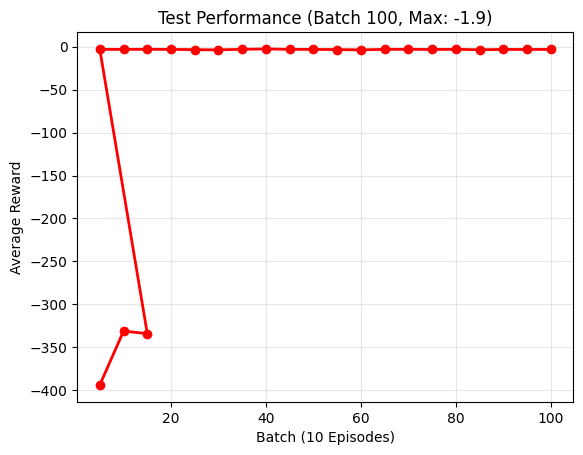

 10%|█         | 102/1000 [04:51<42:30,  2.84s/it]

Training Batch 102: Collected 63 timesteps Episode Count: 5


 10%|█         | 103/1000 [04:53<37:11,  2.49s/it]

Training Batch 103: Collected 41 timesteps Episode Count: 5


 10%|█         | 104/1000 [04:57<44:14,  2.96s/it]

Training Batch 104: Collected 83 timesteps Episode Count: 5


 10%|█         | 105/1000 [05:00<45:46,  3.07s/it]

Training Batch 105: Collected 88 timesteps Episode Count: 5
Training Batch 106: Collected 55 timesteps Episode Count: 5


 11%|█         | 106/1000 [05:04<51:05,  3.43s/it]

Episode 105: Avg Test Reward = -3.24, Max Test Reward = -1.91


 11%|█         | 107/1000 [05:07<45:26,  3.05s/it]

Training Batch 107: Collected 42 timesteps Episode Count: 5


 11%|█         | 108/1000 [05:09<43:54,  2.95s/it]

Training Batch 108: Collected 64 timesteps Episode Count: 5


 11%|█         | 109/1000 [05:11<38:15,  2.58s/it]

Training Batch 109: Collected 43 timesteps Episode Count: 5


 11%|█         | 110/1000 [05:13<36:09,  2.44s/it]

Training Batch 110: Collected 55 timesteps Episode Count: 5
Training Batch 111: Collected 64 timesteps Episode Count: 5
Episode 110: Avg Test Reward = -3.14, Max Test Reward = -1.94


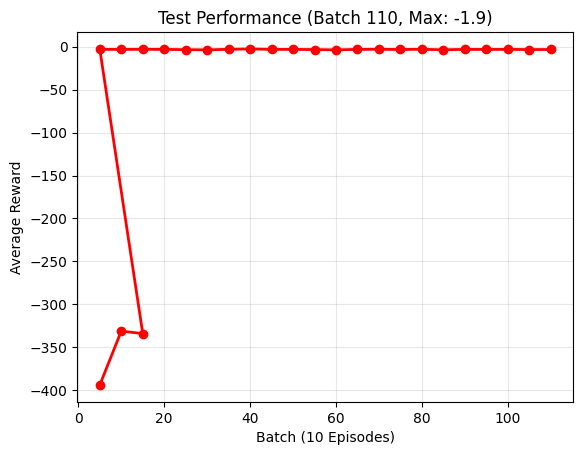

 11%|█         | 112/1000 [05:20<43:17,  2.92s/it]

Training Batch 112: Collected 45 timesteps Episode Count: 5


 11%|█▏        | 113/1000 [05:22<38:33,  2.61s/it]

Training Batch 113: Collected 49 timesteps Episode Count: 5


 11%|█▏        | 114/1000 [05:24<35:51,  2.43s/it]

Training Batch 114: Collected 52 timesteps Episode Count: 5


 12%|█▏        | 115/1000 [05:27<36:13,  2.46s/it]

Training Batch 115: Collected 66 timesteps Episode Count: 5
Training Batch 116: Collected 67 timesteps Episode Count: 5


 12%|█▏        | 116/1000 [05:32<50:09,  3.40s/it]

Episode 115: Avg Test Reward = -3.25, Max Test Reward = -1.91


 12%|█▏        | 117/1000 [05:34<41:05,  2.79s/it]

Training Batch 117: Collected 35 timesteps Episode Count: 5


 12%|█▏        | 118/1000 [05:36<37:24,  2.54s/it]

Training Batch 118: Collected 51 timesteps Episode Count: 5


 12%|█▏        | 119/1000 [05:38<34:06,  2.32s/it]

Training Batch 119: Collected 46 timesteps Episode Count: 5


 12%|█▏        | 120/1000 [05:39<31:38,  2.16s/it]

Training Batch 120: Collected 46 timesteps Episode Count: 5
Training Batch 121: Collected 66 timesteps Episode Count: 5
Episode 120: Avg Test Reward = -2.81, Max Test Reward = -1.91


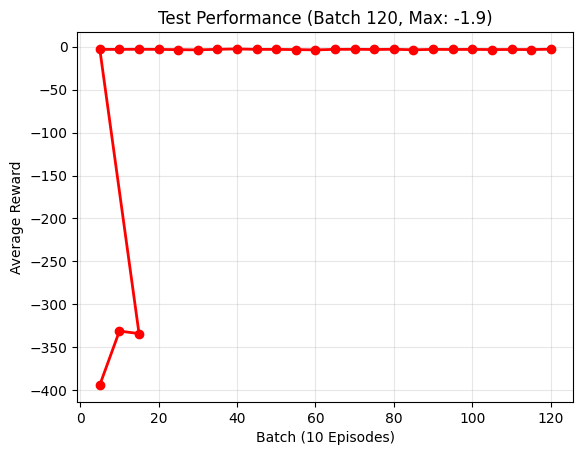

 12%|█▏        | 122/1000 [05:47<44:20,  3.03s/it]

Training Batch 122: Collected 76 timesteps Episode Count: 5


 12%|█▏        | 123/1000 [05:50<43:52,  3.00s/it]

Training Batch 123: Collected 79 timesteps Episode Count: 5


 12%|█▏        | 124/1000 [05:52<39:16,  2.69s/it]

Training Batch 124: Collected 53 timesteps Episode Count: 5


 12%|█▎        | 125/1000 [05:55<39:56,  2.74s/it]

Training Batch 125: Collected 66 timesteps Episode Count: 5
Training Batch 126: Collected 34 timesteps Episode Count: 5


 13%|█▎        | 126/1000 [05:59<44:31,  3.06s/it]

Episode 125: Avg Test Reward = -3.02, Max Test Reward = -1.91


 13%|█▎        | 127/1000 [06:01<37:39,  2.59s/it]

Training Batch 127: Collected 38 timesteps Episode Count: 5


 13%|█▎        | 128/1000 [06:03<37:15,  2.56s/it]

Training Batch 128: Collected 66 timesteps Episode Count: 5


 13%|█▎        | 129/1000 [06:05<33:51,  2.33s/it]

Training Batch 129: Collected 47 timesteps Episode Count: 5


 13%|█▎        | 130/1000 [06:06<29:33,  2.04s/it]

Training Batch 130: Collected 34 timesteps Episode Count: 5
Training Batch 131: Collected 50 timesteps Episode Count: 5
Episode 130: Avg Test Reward = -2.82, Max Test Reward = -1.91


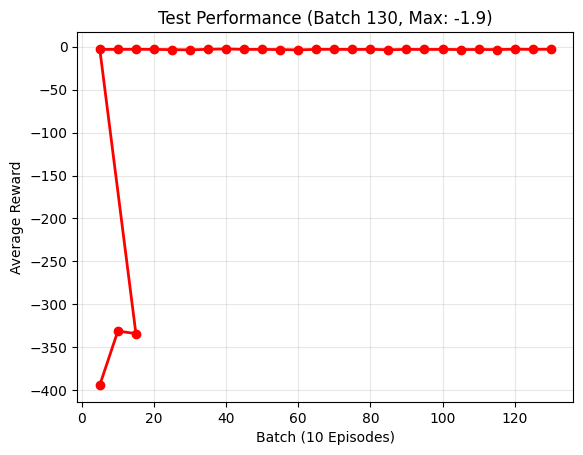

 13%|█▎        | 132/1000 [06:14<40:31,  2.80s/it]

Training Batch 132: Collected 74 timesteps Episode Count: 5


 13%|█▎        | 133/1000 [06:16<38:05,  2.64s/it]

Training Batch 133: Collected 58 timesteps Episode Count: 5


 13%|█▎        | 134/1000 [06:19<39:04,  2.71s/it]

Training Batch 134: Collected 76 timesteps Episode Count: 5


 14%|█▎        | 135/1000 [06:22<41:29,  2.88s/it]

Training Batch 135: Collected 64 timesteps Episode Count: 5
Training Batch 136: Collected 54 timesteps Episode Count: 5


 14%|█▎        | 136/1000 [06:26<46:12,  3.21s/it]

Episode 135: Avg Test Reward = -2.92, Max Test Reward = -1.91


 14%|█▎        | 137/1000 [06:28<39:22,  2.74s/it]

Training Batch 137: Collected 43 timesteps Episode Count: 5


 14%|█▍        | 138/1000 [06:31<43:23,  3.02s/it]

Training Batch 138: Collected 99 timesteps Episode Count: 5


 14%|█▍        | 139/1000 [06:34<43:25,  3.03s/it]

Training Batch 139: Collected 63 timesteps Episode Count: 5


 14%|█▍        | 140/1000 [06:36<37:00,  2.58s/it]

Training Batch 140: Collected 41 timesteps Episode Count: 5
Training Batch 141: Collected 55 timesteps Episode Count: 5
Episode 140: Avg Test Reward = -2.92, Max Test Reward = -1.91


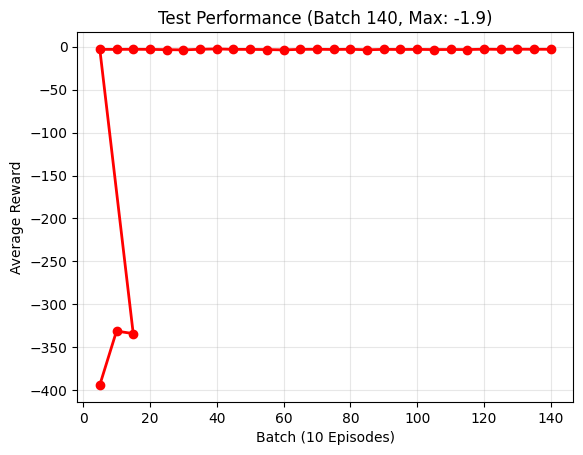

 14%|█▍        | 142/1000 [06:42<39:47,  2.78s/it]

Training Batch 142: Collected 63 timesteps Episode Count: 5


 14%|█▍        | 143/1000 [06:46<42:46,  2.99s/it]

Training Batch 143: Collected 70 timesteps Episode Count: 5


 14%|█▍        | 144/1000 [06:47<37:50,  2.65s/it]

Training Batch 144: Collected 50 timesteps Episode Count: 5


 14%|█▍        | 145/1000 [06:49<32:00,  2.25s/it]

Training Batch 145: Collected 35 timesteps Episode Count: 5
Training Batch 146: Collected 86 timesteps Episode Count: 5


 15%|█▍        | 146/1000 [06:54<42:37,  2.99s/it]

Episode 145: Avg Test Reward = -2.71, Max Test Reward = -1.91


 15%|█▍        | 147/1000 [06:55<36:17,  2.55s/it]

Training Batch 147: Collected 39 timesteps Episode Count: 5


 15%|█▍        | 148/1000 [06:58<36:05,  2.54s/it]

Training Batch 148: Collected 46 timesteps Episode Count: 5


 15%|█▍        | 149/1000 [07:00<35:34,  2.51s/it]

Training Batch 149: Collected 64 timesteps Episode Count: 5


 15%|█▌        | 150/1000 [07:02<34:29,  2.43s/it]

Training Batch 150: Collected 59 timesteps Episode Count: 5
Training Batch 151: Collected 32 timesteps Episode Count: 5
Episode 150: Avg Test Reward = -2.92, Max Test Reward = -1.91


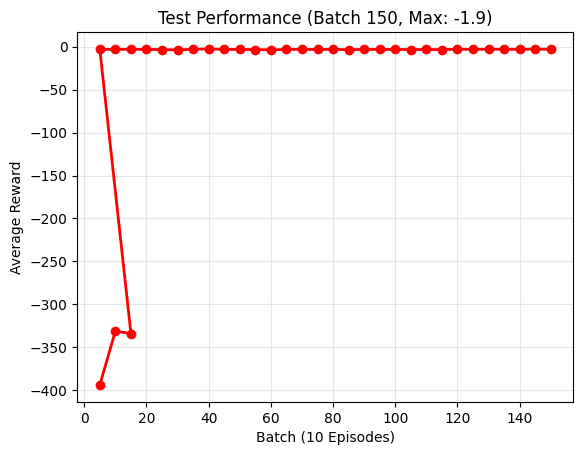

 15%|█▌        | 152/1000 [07:09<40:09,  2.84s/it]

Training Batch 152: Collected 75 timesteps Episode Count: 5


 15%|█▌        | 153/1000 [07:12<41:07,  2.91s/it]

Training Batch 153: Collected 71 timesteps Episode Count: 5


 15%|█▌        | 154/1000 [07:13<33:54,  2.40s/it]

Training Batch 154: Collected 31 timesteps Episode Count: 5


 16%|█▌        | 155/1000 [07:14<29:31,  2.10s/it]

Training Batch 155: Collected 35 timesteps Episode Count: 5
Training Batch 156: Collected 23 timesteps Episode Count: 5


 16%|█▌        | 156/1000 [07:17<31:27,  2.24s/it]

Episode 155: Avg Test Reward = -2.60, Max Test Reward = -1.91


 16%|█▌        | 157/1000 [07:19<29:28,  2.10s/it]

Training Batch 157: Collected 46 timesteps Episode Count: 5


 16%|█▌        | 158/1000 [07:24<41:47,  2.98s/it]

Training Batch 158: Collected 117 timesteps Episode Count: 5


 16%|█▌        | 159/1000 [07:25<34:37,  2.47s/it]

Training Batch 159: Collected 32 timesteps Episode Count: 5


 16%|█▌        | 160/1000 [07:27<30:53,  2.21s/it]

Training Batch 160: Collected 43 timesteps Episode Count: 5
Training Batch 161: Collected 69 timesteps Episode Count: 5
Episode 160: Avg Test Reward = -3.47, Max Test Reward = -1.93


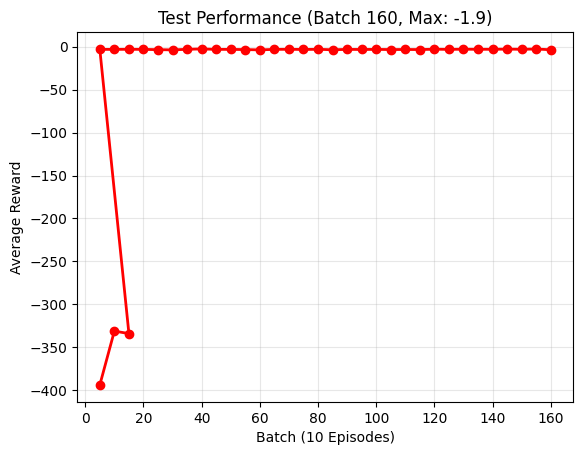

 16%|█▌        | 162/1000 [07:35<41:54,  3.00s/it]

Training Batch 162: Collected 54 timesteps Episode Count: 5


 16%|█▋        | 163/1000 [07:37<41:28,  2.97s/it]

Training Batch 163: Collected 79 timesteps Episode Count: 5


 16%|█▋        | 164/1000 [07:39<35:37,  2.56s/it]

Training Batch 164: Collected 42 timesteps Episode Count: 5


 16%|█▋        | 165/1000 [07:40<30:27,  2.19s/it]

Training Batch 165: Collected 33 timesteps Episode Count: 5
Training Batch 166: Collected 71 timesteps Episode Count: 5


 17%|█▋        | 166/1000 [07:45<41:20,  2.97s/it]

Episode 165: Avg Test Reward = -2.81, Max Test Reward = -1.91


 17%|█▋        | 167/1000 [07:48<39:36,  2.85s/it]

Training Batch 167: Collected 53 timesteps Episode Count: 5


 17%|█▋        | 168/1000 [07:50<35:00,  2.53s/it]

Training Batch 168: Collected 49 timesteps Episode Count: 5


 17%|█▋        | 169/1000 [07:53<37:57,  2.74s/it]

Training Batch 169: Collected 89 timesteps Episode Count: 5


 17%|█▋        | 170/1000 [07:55<37:26,  2.71s/it]

Training Batch 170: Collected 70 timesteps Episode Count: 5
Training Batch 171: Collected 48 timesteps Episode Count: 5
Episode 170: Avg Test Reward = -3.15, Max Test Reward = -1.91


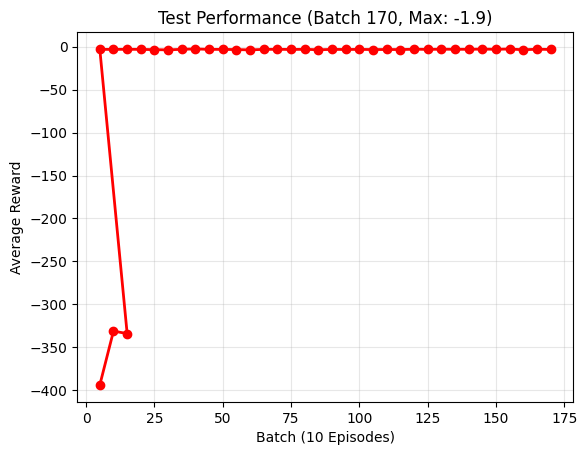

 17%|█▋        | 172/1000 [08:02<40:59,  2.97s/it]

Training Batch 172: Collected 58 timesteps Episode Count: 5


 17%|█▋        | 173/1000 [08:05<38:19,  2.78s/it]

Training Batch 173: Collected 64 timesteps Episode Count: 5


 17%|█▋        | 174/1000 [08:06<31:56,  2.32s/it]

Training Batch 174: Collected 33 timesteps Episode Count: 5


 18%|█▊        | 175/1000 [08:07<28:20,  2.06s/it]

Training Batch 175: Collected 39 timesteps Episode Count: 5
Training Batch 176: Collected 60 timesteps Episode Count: 5


 18%|█▊        | 176/1000 [08:12<38:58,  2.84s/it]

Episode 175: Avg Test Reward = -2.61, Max Test Reward = -1.91


 18%|█▊        | 177/1000 [08:13<33:23,  2.43s/it]

Training Batch 177: Collected 40 timesteps Episode Count: 5


 18%|█▊        | 178/1000 [08:17<36:51,  2.69s/it]

Training Batch 178: Collected 88 timesteps Episode Count: 5


 18%|█▊        | 179/1000 [08:19<34:36,  2.53s/it]

Training Batch 179: Collected 57 timesteps Episode Count: 5


 18%|█▊        | 180/1000 [08:21<33:30,  2.45s/it]

Training Batch 180: Collected 60 timesteps Episode Count: 5
Training Batch 181: Collected 68 timesteps Episode Count: 5
Episode 180: Avg Test Reward = -3.15, Max Test Reward = -1.91


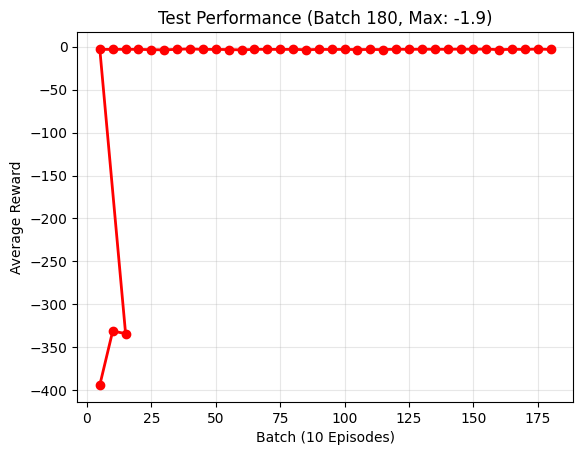

 18%|█▊        | 182/1000 [08:28<38:20,  2.81s/it]

Training Batch 182: Collected 41 timesteps Episode Count: 5


 18%|█▊        | 183/1000 [08:30<35:15,  2.59s/it]

Training Batch 183: Collected 57 timesteps Episode Count: 5


 18%|█▊        | 184/1000 [08:32<31:20,  2.30s/it]

Training Batch 184: Collected 44 timesteps Episode Count: 5


 18%|█▊        | 185/1000 [08:34<32:06,  2.36s/it]

Training Batch 185: Collected 56 timesteps Episode Count: 5
Training Batch 186: Collected 40 timesteps Episode Count: 5


 19%|█▊        | 186/1000 [08:38<38:53,  2.87s/it]

Episode 185: Avg Test Reward = -3.14, Max Test Reward = -1.91


 19%|█▊        | 187/1000 [08:40<32:49,  2.42s/it]

Training Batch 187: Collected 36 timesteps Episode Count: 5


 19%|█▉        | 188/1000 [08:42<31:15,  2.31s/it]

Training Batch 188: Collected 55 timesteps Episode Count: 5


 19%|█▉        | 189/1000 [08:44<29:20,  2.17s/it]

Training Batch 189: Collected 50 timesteps Episode Count: 5


 19%|█▉        | 190/1000 [08:46<29:55,  2.22s/it]

Training Batch 190: Collected 57 timesteps Episode Count: 5
Training Batch 191: Collected 54 timesteps Episode Count: 5
Episode 190: Avg Test Reward = -3.03, Max Test Reward = -1.91


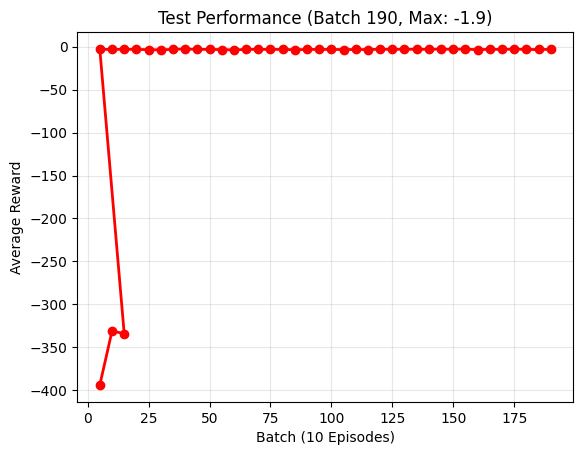

 19%|█▉        | 192/1000 [08:53<35:25,  2.63s/it]

Training Batch 192: Collected 49 timesteps Episode Count: 5


 19%|█▉        | 193/1000 [08:55<33:04,  2.46s/it]

Training Batch 193: Collected 54 timesteps Episode Count: 5


 19%|█▉        | 194/1000 [08:57<30:57,  2.30s/it]

Training Batch 194: Collected 52 timesteps Episode Count: 5


 20%|█▉        | 195/1000 [09:00<33:51,  2.52s/it]

Training Batch 195: Collected 63 timesteps Episode Count: 5
Training Batch 196: Collected 81 timesteps Episode Count: 5


 20%|█▉        | 196/1000 [09:04<42:09,  3.15s/it]

Episode 195: Avg Test Reward = -2.71, Max Test Reward = -1.91


 20%|█▉        | 197/1000 [09:08<43:33,  3.26s/it]

Training Batch 197: Collected 100 timesteps Episode Count: 5


 20%|█▉        | 198/1000 [09:11<42:07,  3.15s/it]

Training Batch 198: Collected 71 timesteps Episode Count: 5


 20%|█▉        | 199/1000 [09:12<35:30,  2.66s/it]

Training Batch 199: Collected 28 timesteps Episode Count: 5


 20%|██        | 200/1000 [09:13<29:46,  2.23s/it]

Training Batch 200: Collected 32 timesteps Episode Count: 5
Training Batch 201: Collected 48 timesteps Episode Count: 5
Episode 200: Avg Test Reward = -2.81, Max Test Reward = -1.91


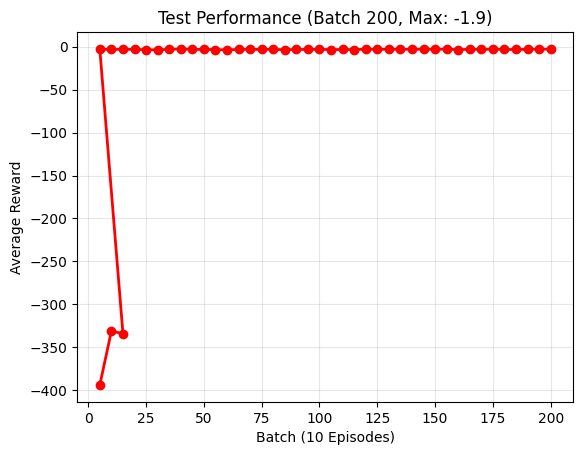

 20%|██        | 202/1000 [09:18<29:49,  2.24s/it]

Training Batch 202: Collected 32 timesteps Episode Count: 5


 20%|██        | 203/1000 [09:20<28:04,  2.11s/it]

Training Batch 203: Collected 49 timesteps Episode Count: 5


 20%|██        | 204/1000 [09:22<27:30,  2.07s/it]

Training Batch 204: Collected 50 timesteps Episode Count: 5


 20%|██        | 205/1000 [09:24<25:52,  1.95s/it]

Training Batch 205: Collected 27 timesteps Episode Count: 5
Training Batch 206: Collected 42 timesteps Episode Count: 5


 21%|██        | 206/1000 [09:27<32:18,  2.44s/it]

Episode 205: Avg Test Reward = -3.14, Max Test Reward = -1.91


 21%|██        | 207/1000 [09:30<33:21,  2.52s/it]

Training Batch 207: Collected 76 timesteps Episode Count: 5


 21%|██        | 208/1000 [09:32<30:17,  2.30s/it]

Training Batch 208: Collected 48 timesteps Episode Count: 5


 21%|██        | 209/1000 [09:34<28:11,  2.14s/it]

Training Batch 209: Collected 48 timesteps Episode Count: 5


 21%|██        | 210/1000 [09:38<35:26,  2.69s/it]

Training Batch 210: Collected 89 timesteps Episode Count: 5
Training Batch 211: Collected 36 timesteps Episode Count: 5
Episode 210: Avg Test Reward = -3.02, Max Test Reward = -1.91


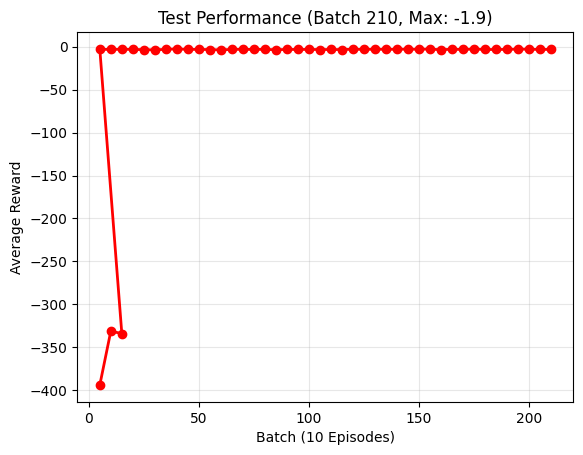

 21%|██        | 212/1000 [09:43<32:37,  2.48s/it]

Training Batch 212: Collected 40 timesteps Episode Count: 5


 21%|██▏       | 213/1000 [09:45<31:59,  2.44s/it]

Training Batch 213: Collected 64 timesteps Episode Count: 5


 21%|██▏       | 214/1000 [09:47<31:01,  2.37s/it]

Training Batch 214: Collected 46 timesteps Episode Count: 5


 22%|██▏       | 215/1000 [09:49<30:02,  2.30s/it]

Training Batch 215: Collected 49 timesteps Episode Count: 5
Training Batch 216: Collected 28 timesteps Episode Count: 5


 22%|██▏       | 216/1000 [09:52<33:20,  2.55s/it]

Episode 215: Avg Test Reward = -3.26, Max Test Reward = -1.91


 22%|██▏       | 217/1000 [09:55<32:29,  2.49s/it]

Training Batch 217: Collected 64 timesteps Episode Count: 5


 22%|██▏       | 218/1000 [09:58<34:00,  2.61s/it]

Training Batch 218: Collected 80 timesteps Episode Count: 5


 22%|██▏       | 218/1000 [10:00<35:55,  2.76s/it]

Training Batch 219: Collected 53 timesteps Episode Count: 5


ValueError: Expected parameter loc (Tensor of shape (53, 1)) of distribution Normal(loc: torch.Size([53, 1]), scale: torch.Size([53, 1])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]], device='cuda:0', grad_fn=<SplitBackward0>)

In [12]:
rollout_size = 5

# Training loop
for batch in tqdm.tqdm(range(nb_batches)):

    # PPO Initialization
    advantages = torch.zeros(max_timesteps_per_rollout*rollout_size, dtype=torch.float32, device=device)
    buffer_states = torch.zeros((max_timesteps_per_rollout*rollout_size, state_dim), dtype=torch.float32, device=device)
    buffer_actions = torch.zeros((max_timesteps_per_rollout*rollout_size, action_dim), dtype=torch.float32, device=device)
    buffer_log_probs = torch.zeros((max_timesteps_per_rollout*rollout_size), dtype=torch.float32, device=device)
    buffer_state_values = torch.zeros((max_timesteps_per_rollout*rollout_size+1), dtype=torch.float32, device=device)
    buffer_rewards = torch.zeros((max_timesteps_per_rollout*rollout_size), dtype=torch.float32, device=device)
    buffer_is_terminal = torch.zeros((max_timesteps_per_rollout*rollout_size), dtype=torch.float32, device=device)

    # Env Initialization
    obs, _ = env.reset()
    state_manager.update(obs)

    # Initialize target_id
    target_id = env.unwrapped.vehicle.lane_index[-1]
    agent_state = state_manager.ego_state_agent(target_id=target_id)

    # Episode Reset
    obs, _ = env.reset()
    state_manager.update(obs)
    done = False
    obs_old = obs
    episode_step = 0
    episode_return = 0.0
    t = 0
    rollout = 0

    while not done and rollout < rollout_size:
      gap_control = Gap_Controller(obs, following_gap_threshold=30)
      activated_target_lane = gap_control.lane_checker()

      # Determine target lane
      target_id = activated_target_lane
      agent_state = state_manager.ego_state_agent(target_id=target_id)

      # Convert agent state dict to tensor
      state_tensor = torch.tensor(
          [agent_state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
          dtype=torch.float32, device=device
      ).unsqueeze(0)

      # Get action and value from model
      with torch.no_grad():
          agent_action, log_prob, value = model.action(state_tensor)
          action = state_manager.action(obs,agent_action)

      # Take action in environment
      obs, reward, done, truncated, info = env.step(action)
      done = done or truncated

      # Terminal conditions
      if info["crashed"] or not env.unwrapped.vehicle.on_road or t>=max_timesteps_per_rollout:
          done = True

      # Update state manager with new observation and applied longitudinal control
      state_manager.update(obs)

      # Compute reward based on the new state
      reward_components = state_manager.reward_function(obs_old, obs, target_id)
      reward = reward_components[0]

      # Store trajectory information
      buffer_states[t] = state_tensor.squeeze(0)
      buffer_actions[t] = agent_action
      buffer_log_probs[t] = log_prob
      buffer_state_values[t] = value
      buffer_rewards[t] = torch.tensor(reward, dtype=torch.float32, device=device)
      buffer_is_terminal[t] = done

      t += 1  # Increment timestep counter
      obs_old = obs

      # If episode is done, increment rollout and reset for next episode
      if done:
          rollout += 1
          if rollout < rollout_size:
              obs, _ = env.reset()
              state_manager.update(obs)
              done = False
              obs_old = obs

    # Print rollout info
    print(f"Training Batch {batch+1}: Collected {t} timesteps Episode Count: {rollout}")

    # Calculate advantages using GAE
    gae = 0
    advantages = torch.zeros(t, dtype=torch.float32, device=device)

    for t_idx in range(t-1, -1, -1):
        if buffer_is_terminal[t_idx]:
            terminal = 1
            next_value = 0
        else:
            terminal = 0
            if t_idx == t-1:
                next_value = 0
            else:
                next_value = buffer_state_values[t_idx+1]

        delta = buffer_rewards[t_idx] + gamma * next_value * (1-terminal) - buffer_state_values[t_idx]
        gae = delta + (gamma * gae_lambda) * gae * (1-terminal)
        advantages[t_idx] = gae

    # Prepare data for policy update
    advantages_data_loader = DataLoader(
        TensorDataset(
            advantages.detach(),
            buffer_states[:t].detach(),
            buffer_actions[:t].detach(),
            buffer_log_probs[:t].detach(),
            buffer_state_values[:t].detach()),
        batch_size=min(batch_size, t),
        shuffle=True)

    # Policy update (K epochs)
    for epoch in range(K):
        for batch_data in advantages_data_loader:
            b_adv, obs_batch, action_batch, old_log_probs, old_state_values = batch_data

            # Forward pass
            dist, value = model(obs_batch)
            log_probs = dist.log_prob(action_batch)

            # Calculate ratio
            ratio = torch.exp(log_probs - old_log_probs)
            returns = b_adv + old_state_values

            # Policy loss
            policy_loss_1 = b_adv * ratio
            policy_loss_2 = b_adv * torch.clamp(ratio, 1-epsilon, 1+epsilon)
            policy_loss = -torch.min(policy_loss_1, policy_loss_2).mean()

            actor_loss = policy_loss - ent_coef_c2 * dist.entropy().mean()
            critic_loss = F.mse_loss(value.squeeze(),returns)

            # Optimize
            # For the actor:
            actor_optimizer.zero_grad() # Clear gradients for actor
            actor_loss.backward()       # Compute gradients for actor_loss w.r.t. actor_params
            actor_optimizer.step()      # Update actor_params

            # For the critic:
            critic_optimizer.zero_grad() # Clear gradients for critic
            critic_loss.backward()       # Compute gradients for critic_loss w.r.t. critic_params
            critic_optimizer.step()

    # Testing every 5 batches
    if batch % test_rate == 0 and batch > 0:
        num_test = 1
        test_rewards = []

        for test_ep in range(10):  # 10 test episodes
            obs, _ = env.reset()
            obs_old = obs
            state_manager = ENV(obs,control_parameters=control_parameters,desired_parameters=desired_parameters)
            episode_reward = 0
            done = False
            test_steps = 0

            while not done and test_steps < 500:  # Limit test episode
                gap_control = Gap_Controller(obs, following_gap_threshold=30)
                activated_target_lane = gap_control.lane_checker()

                # Determine target lane
                target_id = activated_target_lane
                agent_state = state_manager.ego_state_agent(target_id=target_id)

                state_tensor = torch.tensor(
                    [agent_state[key] for key in ['vx', 'longitudinal_acceleration', 'x', 'y', 'thetha', 'lane_id', 'lane_width', 'self_curvature']],
                    dtype=torch.float32, device=device
                ).unsqueeze(0)

                with torch.no_grad():
                    agent_action, log_prob, value = model.action(state_tensor,deterministic=True)

                action = state_manager.action(obs, agent_action)

                obs, _, done, truncated, info = env.step(action)
                done = done or truncated

                # Terminal conditions
                if info["crashed"] or not env.unwrapped.vehicle.on_road or t>=max_timesteps_per_rollout:
                    done = True

                state_manager.update(obs)
                reward_components = state_manager.reward_function(obs_old, obs, target_id)
                reward = reward_components[0]

                episode_reward += reward
                test_steps += 1
                obs_old = obs

            test_rewards.append(episode_reward)

        avg_test_reward = sum(test_rewards) / len(test_rewards)
        current_max = max(test_rewards)

        if current_max > max_reward:
            max_reward = current_max

        batch_average_reward_history.append(avg_test_reward)
        batch_episode_history.append(batch)

        print(f"Episode {batch}: Avg Test Reward = {avg_test_reward:.2f}, Max Test Reward = {current_max:.2f}")

    # Plot every 50 btaches
    if batch % 10 == 0 and batch > 0 and len(batch_average_reward_history) > 0:
      plt.plot(batch_episode_history, batch_average_reward_history, 'r-o', linewidth=2)
      plt.title(f"Test Performance (Batch {batch}, Max: {max_reward:.1f})")
      plt.xlabel("Batch (10 Episodes)")
      plt.ylabel("Average Reward")
      plt.grid(True, alpha=0.3)
      plt.show()

print("Training completed!")